# Modern Portfolio Theory

## Model

<details>
  <summary>Assumptions</summary>
  
  ### Assumptions

* Investors are risk averse, meaning that given two portfolios that offer the same expected return, investors will prefer the less risky one. 

* An investor will take on increased risk only if compensated by higher expected returns. 

* Conversely, an investor who wants higher expected returns must accept more risk. 

* The exact trade-off will be the same for all investors, but different investors will evaluate the trade-off differently based on individual risk aversion characteristics. 

* The implication is that a rational investor will not invest in a portfolio if a second portfolio exists with a more favorable risk-expected return profile – i.e., if for that level of risk an alternative portfolio exists that has better expected returns.

* There are 252 trading days in a calendar year on average.
</details>

### Modules

First we import the modules needed for making the workbook work

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import ipywidgets as widgets
import scipy.stats as scs
import scipy.optimize as sco
import statsmodels.api as sm
import scipy.interpolate as sci
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
plt.style.use('ggplot')
np.random.seed(1479)

In [2]:
def yprices(name, start, end):
    '''    
        Arguments: 
            name(string)    : input the ticker for the desired stock
            start(datetime) : Setting a starting date
            end(datetime)   : Setting a ending date 
         Returns:
            The function returns a Pandas DataFrame webscraped from yahoo finance containing the Date, High, Low, Close, Adj Close and Volume for the inquired stock 
            More information can be found at https://github.com/ranaroussi/fix-yahoo-finance
    '''
    yf.pdr_override() # Command to override the pandas search function
    return pdr.get_data_yahoo(name, start, end)

### Data collecting

In [3]:
tickers = ['AAPL', 'MSFT', 'JPM', 'DB', 'GLD']
noa = len(tickers)

In [4]:
start = datetime.datetime(2010, 1, 28)

In [5]:
end = datetime.datetime(2018, 10, 3)

Doing a webscrape of the adjusted close on yahoo for the quoted tickers, and lastly looking at the head and tail of the dataframe to ensure that we have the data needed for making the analysis and ensuring that we can optimize the portfolio

In [57]:
data = pd.DataFrame()
for sym in tickers:
    data[sym] = yprices(sym, start, end)['Adj Close']
data.columns = tickers
#loop that creates a dataframe
data.iloc[np.r_[0:2, -2:0]]

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


,AAPL,MSFT,JPM,DB,GLD
Date,,,,,
2010-01-27,19.802147,23.597769,31.211039,51.200840,106.529999
2010-01-28,18.983883,23.192135,31.330078,50.284924,106.480003
2018-10-01,225.502670,114.623184,110.953758,11.250000,112.570000
2018-10-02,227.507050,114.167114,111.413216,11.130000,113.870003


### Data visualization and Analysis

We calculate the log daily returns (percent change compared to the day before). By using daily returns instead of actual prices, we can see the stocks’ volatility.

In [58]:
rets = np.log(data / data.shift(1))
#new column for returns based on the positions above
rets.head(2)
#checking log returns

,AAPL,MSFT,JPM,DB,GLD
Date,,,,,
2010-01-27,NaN,NaN,NaN,NaN,NaN
2010-01-28,-0.0422,-0.017339,0.003807,-0.018051,-0.000469


Text(0, 0.5, 'daily returns')

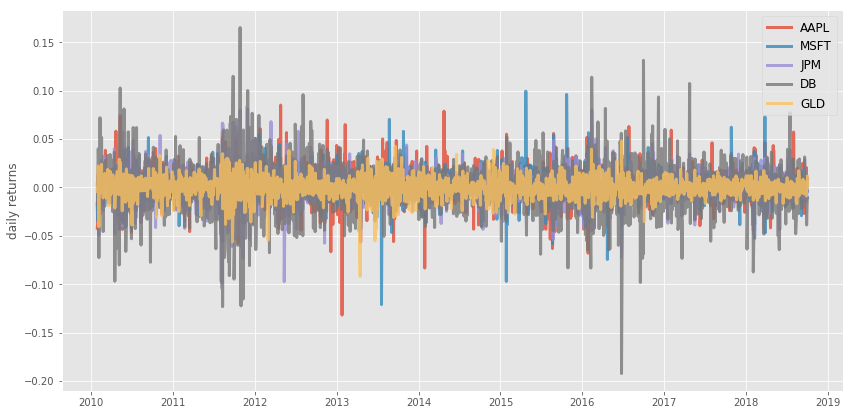

In [59]:
plt.figure(figsize=(14, 7))
for c in rets.columns.values:
    plt.plot(rets.index, rets[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

Deutsche Bank has two distinctive positive spikes and a couple of negative ones. Deutsche Bank has one highest positive spike, but also the highest negative spike. And Apple also has some spikes stand out from the plot. From the above plot, we can roughly see that Deutsche Bank looks like a quite risky stock, and gold seems to be the most stable one among them.

### Means, covariances and other measures

The annualized return of the different stocks

In [9]:
rets.mean() * 252

AAPL    0.281441
MSFT    0.181739
JPM     0.146690
DB     -0.175929
GLD     0.007681
dtype: float64

The annualized covariance matrix

In [10]:
rets.cov()*252

,AAPL,MSFT,JPM,DB,GLD
AAPL,0.063694,0.023250,0.022396,0.031590,0.001327
MSFT,0.023250,0.050130,0.026977,0.036669,-0.000468
JPM,0.022396,0.026977,0.065390,0.067839,-0.003084
DB,0.031590,0.036669,0.067839,0.160622,0.000175
GLD,0.001327,-0.000468,-0.003084,0.000175,0.025668


#### Portfolio weights

In [11]:
weights = np.random.random(noa)
#new numpy array of 4 random number that add up to 1
weights /= np.sum(weights)
#second line assures weight are equal to 1
weights

array([0.05282443, 0.3201937 , 0.27244896, 0.01352046, 0.34101245])

In [12]:
weights.sum()

1.0

Expected return of i'th portfolio $\mathbb{E} R_{i}=w_{i, j}^{T} \times \mathbb{E} R_{j}$

In [13]:
np.sum(rets.mean() * weights) * 252

0.11326471685712543

Volatility of i'th portfolio $\sigma_{i}^{2}=w_{i, j}^{T} \times \operatorname{cov}\left(R_{j}\right) \times w_{i, j}$

In [14]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.01955983364085654

Standard Deviations of the i'th portfolio $\sqrt{\sigma_{i}^{2}=w_{i, j}^{T} \times \operatorname{cov}\left(R_{j}\right) \times w_{i, j}}$

In [15]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.1398564751481194

### Monte Carlo simulation

In [16]:
prets = [] # portfolio returns
pvols = [] # portfolio variance
#prets and vols are np.arrays
for p in range (50000):
 #loop underlines number of iterations for a random weighing
 weights = np.random.random(noa)
 weights /= np.sum(weights)
 #this makes it equal to 1
 prets.append(np.sum(rets.mean() * weights) * 252)
 #i get a value for each loop
 pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
  #covariance value for each loop

prets = np.array(prets)
pvols = np.array(pvols)
#turns prets and pvols from lists into numpy arrays
print("Simulation done")

Simulation done


#### Visualization

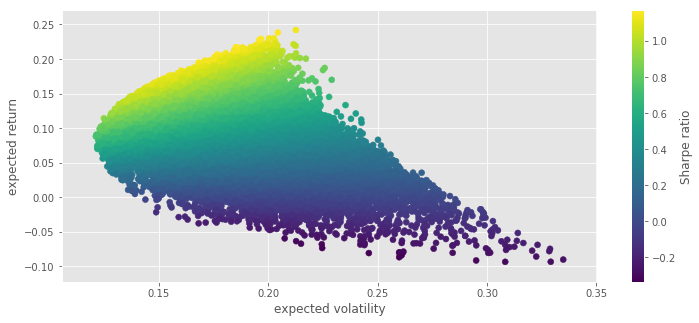

In [17]:
plt.figure(figsize=(12, 5))
plt.scatter(pvols, prets, c = prets / pvols, marker='o', cmap='viridis')
# c is a calculated column of a sharpe ratio minus a risk free rate
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

Now we build a portfolio function that, for a given vector of portfolio weights $w_i$, so that the function returns the portfolio’s expected return, volatility, and the Sharpe ratio (as a vector).

The sharpe ratio is defined as the risk-adjusted measure of performance for at stock


$S_a  =\frac{R_{p}-R_{f}}{\sigma_{p}}$

where

$\begin{aligned} R_{p} &=\textit { Return of portfolio } \\ R_{f} &=\textit { Risk-free rate } \\ \sigma_{p} &=\textit { Standard deviation of the portfolio's excess return } \end{aligned}$

In [18]:
def portfolio(weights):
 weights = np.array(weights)
 pret = np.sum(rets.mean() * weights) * 252 # Portfolio annulized return
 pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))) # Portfolio annulized standard deviation
 return np.array([pret, pvol, pret / pvol]) # Portfolio annulized return, Portfolio annulized standard deviation, Portfolio Sharpe ratio

The output from the portfolio function creates an tuble containing $\mathbb{E} R_{i},\sigma_{i}^{2},S_a$  

We then define a function for the negative Sharpe ratio, and by using the minizie optimization on a negative number, we then get the portfolio maximum sharpe ratio.

In [19]:
def min_func_sharpe(weights):
 return -portfolio(weights)[2]

Set up the constraint that portfolio weights add up to one $\sum^{n}_{i=1}w_i=1$

In [20]:
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
#this is a dictionary with two objects, that constrains the optimization

Set up boundaries for the portfolio weights (between 0 and 1)

In [21]:
bnds = tuple((0, 1) for x in range(noa))

## Maximum Sharpe ratio portfolio

Using Scipy to minimize the negative sharpe ratio portfolio to find the maximum allocation of weights

$\arg \max _{w \in [0,1]}\;\;S_a$

s.t

$\mathbf{w}^{\top} \mathbf{1} =\mathbf{1}$

In [22]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

Wall time: 84.8 ms


In [23]:
opts

     fun: -1.1820334564932349
     jac: array([ 7.44163990e-05, -1.40830874e-04, -1.16348267e-04,  1.86719047e+00,
        4.55528498e-05])
 message: 'Optimization terminated successfully.'
    nfev: 49
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([6.23941367e-01, 3.03080649e-01, 4.35953298e-02, 9.10729825e-17,
       2.93826543e-02])

In [24]:
print(opts['x'].round(2))
print(tickers)
#creates nparray based on key 'x' from the optimization, and rounds to 3 digit

[0.62 0.3  0.04 0.   0.03]
['AAPL', 'MSFT', 'JPM', 'DB', 'GLD']


We see here that the maximum sharpe portfolio allocation, consists of 2/3 Apple  and 1/3 MSFT, and with some small weight amounts on JP Morgan and Gold.
Also we notice that no allocation in Deutsche Bank, which could be based on the fact that the stock faced alot of volatility

Next we print the expected return, volatility and sharpe ratio from the portfolio based on their individual weights and checking that the allocation meets the constraintes of a full invested portfolio

In [25]:
portfolio(opts['x']).round(2)

array([0.24, 0.2 , 1.18])

In [26]:
round(opts['x'].sum(),2)

1.0

## Minimum variance portfolio




Defined as

 $min_{w}\; var[w^T\mu]=w^T\Sigma w$= $\begin{bmatrix}w_1 \cdots w_n\end{bmatrix} \cdot \begin{bmatrix}
\sigma_{n1}^{2}& \cdots & \sigma_{1m}^{2}\\
\vdots     & \ddots & \vdots \\
\sigma_{n1}^{2}& \cdots & \sigma_{nm}^{2}\\
\end{bmatrix}
\cdot
\begin{bmatrix} 
w_1  \\
\vdots  \\
w_n  \\
\end{bmatrix}$ 

st.

$w^T \mu=\mu_{portfolio}$
   
$w^T 1=1$

In [27]:
def min_func_variance(weights):
     return portfolio(weights)[1] ** 2 # portfolio variance

In [28]:
%%time
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds,
constraints=cons)

Wall time: 146 ms


In [29]:
optv

     fun: 0.014553856738640594
     jac: array([0.02871223, 0.02924849, 0.028754  , 0.03847875, 0.02922089])
 message: 'Optimization terminated successfully.'
    nfev: 64
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.00399850e-01, 1.74983413e-01, 1.42768045e-01, 1.57209315e-18,
       5.81848692e-01])

In [30]:
optv['x'].round(3)

array([0.1  , 0.175, 0.143, 0.   , 0.582])

In [31]:
portfolio(optv['x']).round(3)

array([0.085, 0.121, 0.708])

### EFFICIENT FRONTIER

Using Scipy to minimize the minimum variance

$\min _{w \in [0,1]} \operatorname{var}\left[\mathbf{w}^{\top} \mathbf{r}\right]=\mathbf{w}^{\top} \boldsymbol{\Sigma} \mathbf{w}$

s.t

$\begin{aligned} \mathbf{w}^{\top} \boldsymbol{\mu} &=\mu_{\text{target return}} \\ \mathbf{w}^{\top} \mathbf{1} &=1 \end{aligned}$


* We solve this problem for many levels of the target return.
* Each time we do, we get another point on the efficient frontier.
* We need to specify the constraint in a loop, as the target return is always changing.

In [32]:
def min_func_port(weights):
     return portfolio(weights)[1] #portfolio function

In [33]:
cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
#normal bounds for optimization

Define a range for target returns.

In [34]:
%%time
trets = np.linspace(0.0, 0.25,100) # target return, within 0 % to 25 %, 100 samples
tvols = []
for tret in trets:
 cons = ({'type': 'eq', 'fun': lambda x: portfolio(x)[0] - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
 res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
 tvols.append(res['fun'])
tvols = np.array(tvols)

Wall time: 10.3 s


#### Visualization

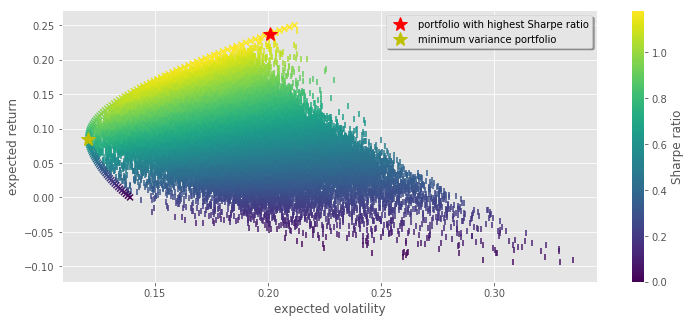

In [35]:
plt.figure(figsize=(12, 5))
plt.scatter(pvols, prets,
 c=prets / pvols, marker='|', cmap ='viridis')
 # random portfolio composition
plt.scatter(tvols, trets,
 c=trets / tvols, marker='x', cmap='viridis')
 # efficient frontier
plt.plot(portfolio(opts['x'])[1], portfolio(opts['x'])[0],
 'r*', markersize=15.0,label ='portfolio with highest Sharpe ratio')
 # portfolio with highest Sharpe ratio
plt.plot(portfolio(optv['x'])[1], portfolio(optv['x'])[0],
 'y*', markersize=15.0,label ='minimum variance portfolio')
 # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.legend(loc='upper right', shadow=True, ncol=1)

# CAPITAL MARKET LINE

The trick is to remember that the return vector is sorted in ascending
order.
Portfolios with returns above the minimum variance portfolio are
non-dominated, so we find the index position of the minimum volatility portfolio along with volatility and return of that particular portfolio.

In [36]:
ind = np.argmin(tvols) # index number of portfolio 
evols = tvols[ind:] # indexed portfolios volatility
erets = trets[ind:] # indexed portolfios return

In [37]:
tck = sci.splrep(evols, erets) # Cubic splines interpolation based
                               # on the indexed portfolios' values of
                               # return and volatility

In [38]:
def f(x):
#Efficient frontier function (splines approximation)
 return sci.splev(x, tck, der=0)
def df(x):
#First derivative of efficient frontier function
 return sci.splev(x, tck, der=1)

* Let $t (x)$ be the capital market line (linear).
* Let $f (x)$ be the efficient frontier function.
* Let $x^∗$ be the tangency portfolio.
* At the tangency portfolio, the CML and efficient frontier have equal values and first derivatives.
* This gives a three-equation system with three unknowns.

$t(x^*)=a+b+x^*$ (Linearity of CML)
    
$t(x^*)=f(x^*)$
   
$t'(x^*)=f'(x^*)$

In [39]:
def equations(z, rf):
    eq1 = rf - z[0]  
    eq2 = rf + z[1] * z[2] - f(z[2])
    eq3 = z[1] - df(z[2])
    return eq1, eq2, eq3

def riskfree(rf):
    return(sco.fsolve(equations, [0.01, 0.5, 0.15], rf))

In [40]:
riskfree(0.06)

array([0.06      , 0.89838647, 0.21533813])

Beneath we create a function CAPM_FIGURE which creates the figure from above, but this time, we make it so we can change the risk free return.
* riskfree(rf)[0] is the capital marked line's intercept on the y-axis.
* riskfree(rf)[1] is the slope of the capital marked line.
* riskfree(rf)[2] is the volatility for the portfolio which is tangent to the capital marked line.
* f(riskfree(rf)[2]) is the function value (return) of the porfolio which is tangent to the capital marked line.
* temp = riskfree(rf) in the code below

In [44]:
def CAPM_FIGURE(rf, pvols=pvols, prets=prets , p=p ):
    plt.figure(figsize=(16, 8))
    plt.scatter(pvols, prets,
    c=(prets - 0.01) / pvols, marker='o', cmap='viridis')
    # random portfolio composition
    plt.plot(evols, erets, 'black', lw=4.0)
    # efficient frontier
    cx = np.linspace(0.0, 0.3)
    temp = riskfree(rf)  #making a temp, so it doesnt have to calculate riskfree over and over. 
    plt.plot(cx, temp[0] + temp[1] * cx, lw=1.5)
    # capital market line
    plt.plot(temp[2], f(temp[2]), 'r*', markersize=15.0)
    plt.grid(True)
    plt.axhline(0, color='k', ls='-', lw=2.0)
    plt.axvline(0, color='k', ls='-', lw=2.0)
    plt.ylim(-0.1 , 0.35)
    plt.xlabel('expected volatility')
    plt.ylabel('expected return')
    plt.colorbar(label='Sharpe ratio')
    plt.show()

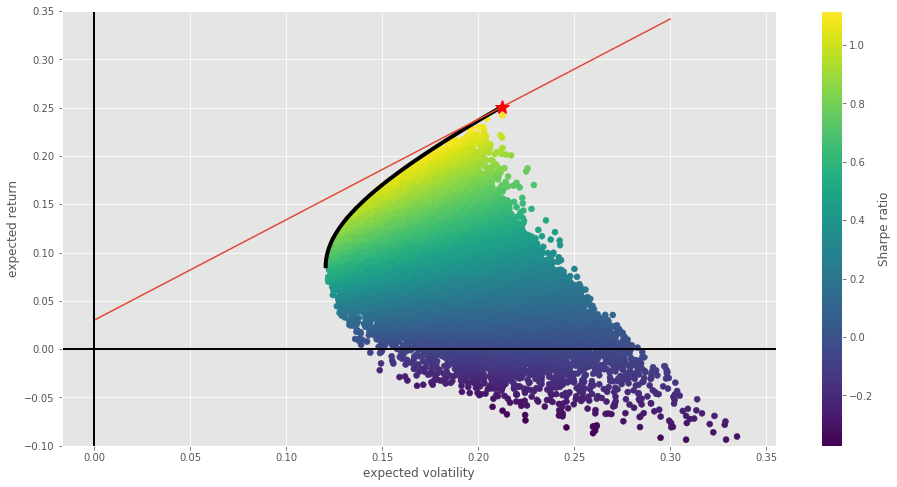

In [45]:
CAPM_FIGURE(0.03)

### The complete model with adjustable riskfree return rate

We are only interested in making our riskfree rate interactive, and therefore keep the other variabels fixed.

In [46]:
widgets.interact(CAPM_FIGURE,
                 rf = widgets.FloatSlider(description="$Riskfree$", min=-0.1, max=0.1, step=0.01, value=0),
                 pvols = widgets.fixed(pvols),
                 prets=widgets.fixed(prets),
                 p=widgets.fixed(p)
                );

interactive(children=(FloatSlider(value=0.0, description='$Riskfree$', max=0.1, min=-0.1, step=0.01), Output()…